Q4 Dataset

Obtained 

In [30]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import dateutil.relativedelta
import matplotlib.pyplot as plt

ticker = "AMZN"
end_date = datetime.strptime("2018-12-31", "%Y-%m-%d")
start_date = end_date - dateutil.relativedelta.relativedelta(months=60)

amzn = yf.download(ticker, start=start_date, end=end_date, interval="1d")["Adj Close"]
amzn = amzn.resample("M").last()
amzn.index = amzn.index.tz_localize(None)

amzn["Monthly_Return"] = amzn.pct_change()
print(len(amzn))

[*********************100%***********************]  1 of 1 completed

61



C:\Users\gianm\AppData\Local\Temp\ipykernel_16148\981473512.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  amzn = amzn.resample("M").last()


Fama-French 3-Factor Model

In [31]:
import getFamaFrenchFactors as ff
import statsmodels.api as sm

ff3_monthly = ff.famaFrench3Factor(frequency='m')  
ff3_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)
ff3_monthly = ff3_monthly.loc[start_date:end_date]

print(ff3_monthly)
print(amzn)

data = pd.DataFrame({
    "AMZN_Return": amzn['Monthly_Return']
}).join(ff3_monthly).dropna()

risk_free_rate = data['RF']
data['Excess_AMZN_Return'] = data['AMZN_Return'] - risk_free_rate
data['Market_Excess_Return'] = data['Mkt-RF']

# Capm Model 
X = data['Market_Excess_Return']
y = data['Excess_AMZN_Return']

X = sm.add_constant(X)  # Add intercept term
model = sm.OLS(y, X).fit()

beta = model.params['Market_Excess_Return']
alpha = model.params['const']
alpha_p_value = model.pvalues['const']


market_excess_return = data['Market_Excess_Return'].mean()
expected_amzn_return = risk_free_rate + beta * market_excess_return


            Mkt-RF     SMB     HML      RF
Date                                      
2013-12-31  0.0281 -0.0047 -0.0002  0.0000
2014-01-31 -0.0332  0.0089 -0.0207  0.0000
2014-02-28  0.0465  0.0034 -0.0031  0.0000
2014-03-31  0.0043 -0.0181  0.0493  0.0000
2014-04-30 -0.0019 -0.0418  0.0117  0.0000
...            ...     ...     ...     ...
2018-08-31  0.0344  0.0115 -0.0400  0.0016
2018-09-30  0.0006 -0.0229 -0.0171  0.0015
2018-10-31 -0.0768 -0.0474  0.0340  0.0019
2018-11-30  0.0169 -0.0068  0.0028  0.0018
2018-12-31 -0.0957 -0.0237 -0.0188  0.0020

[61 rows x 4 columns]
Ticker            AMZN  Monthly_Return
Date                                  
2013-12-31   19.939501             NaN
2014-01-31   17.934500       -0.100554
2014-02-28   18.105000        0.009507
2014-03-31   16.818501       -0.071058
2014-04-30   15.206500       -0.095847
...                ...             ...
2018-08-31  100.635498        0.132364
2018-09-30  100.150002       -0.004824
2018-10-31   79.900497      

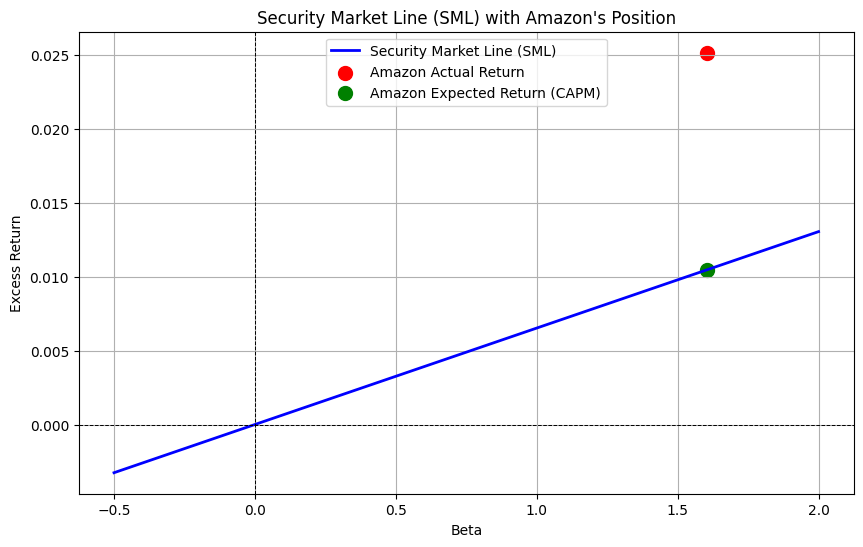

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))

# Security Market Line
betas = [-0.5, 0, 0.5, 1, 1.5, 2]
sml_returns = [risk_free_rate.iloc[0] + b * market_excess_return for b in betas] 
ax.plot(betas, sml_returns, label="Security Market Line (SML)", color="blue", lw=2)

# Amazon's position (Scatter plot of actual vs expected returns)
actual_amzn_return = data['Excess_AMZN_Return'].mean()  # Average excess return for Amazon
ax.scatter(beta, actual_amzn_return, color="red", label="Amazon Actual Return", s=100)
ax.scatter(beta, expected_amzn_return.iloc[0], color="green", label="Amazon Expected Return (CAPM)", s=100)

ax.set_title("Security Market Line (SML) with Amazon's Position")
ax.set_xlabel("Beta")
ax.set_ylabel("Excess Return")
ax.axhline(0, color='black', linestyle='--', lw=0.7)
ax.axvline(0, color='black', linestyle='--', lw=0.7)
ax.legend()
plt.grid()
plt.show()

In [33]:
print(model.params['const'])

0.014697756335227696


Fama-French 3-Factor Mode

In [34]:
X = sm.add_constant(data[['Market_Excess_Return', 'SMB', 'HML']])  # Add constant for alpha
y = data['Excess_AMZN_Return']

# Perform regression
model_ff = sm.OLS(y, X).fit()
alpha = model_ff.params['const']
alpha_p_value = model_ff.pvalues['const']


print('Alpha= ', alpha)
print(f"Alpha p-value: {alpha_p_value:.4f}")
print('Beta of market_excess_returns', model_ff.params[1])
print('Beta of SMB= ', model_ff.params[2])
print('Beta of HML=', model_ff.params[3])

Alpha=  0.010267253442393199
Alpha p-value: 0.2057
Beta of market_excess_returns 1.6531552339592266
Beta of SMB=  -0.5465997494413626
Beta of HML= -1.2960611972237932


C:\Users\gianm\AppData\Local\Temp\ipykernel_16148\1427937235.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Beta of market_excess_returns', model_ff.params[1])
C:\Users\gianm\AppData\Local\Temp\ipykernel_16148\1427937235.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Beta of SMB= ', model_ff.params[2])
C:\Users\gianm\AppData\Local\Temp\ipykernel_16148\1427937235.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Fama-French 5-Factor

In [35]:
ff5_monthly = ff.famaFrench5Factor(frequency='m')  
ff5_monthly.rename(columns={"date_ff_factors": "Date"}, inplace=True)
ff5_monthly.set_index("Date", inplace=True)
ff5_monthly = ff5_monthly.loc[start_date:end_date]

data = pd.DataFrame({
    "AMZN_Return": amzn["Monthly_Return"]
}).join(ff5_monthly).dropna()

risk_free_rate = data["RF"]
data["Excess_AMZN_Return"] = data["AMZN_Return"] - risk_free_rate
data["Market_Excess_Return"] = data["Mkt-RF"]

X = data[["Market_Excess_Return", "SMB", "HML", "RMW", "CMA"]]
X = sm.add_constant(X)  # Add intercept term
model_ff5 = sm.OLS(y, X).fit()

y = data["Excess_AMZN_Return"]

print('Alpha= ', alpha)
print(f"Alpha p-value: {alpha_p_value:.4f}")
print('Beta of market_excess_returns', model_ff.params[1])
print('Beta of SMB= ', model_ff5.params[2])
print('Beta of HML=', model_ff5.params[3])
print('Beta of RMW= ', model_ff5.params[4])
print('Beta of CMA=', model_ff5.params[5])

Alpha=  0.010267253442393199
Alpha p-value: 0.2057
Beta of market_excess_returns 1.6531552339592266
Beta of SMB=  -0.7993798269138309
Beta of HML= -0.6068261039655745
Beta of RMW=  -0.7297989374224839
Beta of CMA= -1.3921577686655426


C:\Users\gianm\AppData\Local\Temp\ipykernel_16148\751373293.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Beta of market_excess_returns', model_ff.params[1])
C:\Users\gianm\AppData\Local\Temp\ipykernel_16148\751373293.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Beta of SMB= ', model_ff5.params[2])
C:\Users\gianm\AppData\Local\Temp\ipykernel_16148\751373293.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po